# Week 02 — Advanced Optimization

This notebook explores advanced optimizers (Momentum, RMSProp, Adam) and learning rate schedules. You'll:
- Implement and compare modern optimizers
- Experiment with LR schedules (step, cosine, warmup)
- Run LR range tests and hyperparameter sweeps

---
### 📚 Theory & References

- [📖 **Week 02 Theory** — Advanced Optimizers](theory.md)
- [Week 01 — Gradient descent, SGD, momentum](../week01_optimization/theory.md#4-gradient-descent)
- [Week 00b — Exponential moving averages](../../01_intro/week00b_math_and_data/theory.md#3-part-ii-calculus-and-optimisation)

---

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:

import os, pickle

CACHE_DIR = "cache_week02"
os.makedirs(CACHE_DIR, exist_ok=True)

def save_result(key, obj):
    with open(os.path.join(CACHE_DIR, f"{key}.pkl"), "wb") as f:
        pickle.dump(obj, f)

def load_result(key):
    path = os.path.join(CACHE_DIR, f"{key}.pkl")
    if os.path.exists(path):
        with open(path, "rb") as f:
            return pickle.load(f)
    return None

def cached(key, compute_fn):
    result = load_result(key)
    if result is not None:
        print(f"[cache] loaded '{key}'")
        return result
    print(f"[cache] computing '{key}'...")
    result = compute_fn()
    save_result(key, result)
    return result

print("Cache utilities ready. Results will be stored in:", CACHE_DIR)


Cache utilities ready. Results will be stored in: cache_week02


## 1. Implement Advanced Optimizers

We'll implement Momentum, RMSProp, and Adam from scratch.

In [3]:
class Optimizer:
    """Base optimizer class"""
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def step(self, params, grads):
        raise NotImplementedError

class MomentumOptimizer(Optimizer):
    """SGD with Momentum"""
    def __init__(self, lr=0.01, momentum=0.9):
        super().__init__(lr)
        self.momentum = momentum
        self.velocity = None
    
    def step(self, params, grads):
        if self.velocity is None:
            self.velocity = np.zeros_like(params)
        
        self.velocity = self.momentum * self.velocity - self.lr * grads
        params += self.velocity
        return params

class RMSPropOptimizer(Optimizer):
    """RMSProp optimizer"""
    def __init__(self, lr=0.01, beta=0.9, eps=1e-8):
        super().__init__(lr)
        self.beta = beta
        self.eps = eps
        self.cache = None
    
    def step(self, params, grads):
        if self.cache is None:
            self.cache = np.zeros_like(params)
        
        self.cache = self.beta * self.cache + (1 - self.beta) * (grads ** 2)
        params -= self.lr * grads / (np.sqrt(self.cache) + self.eps)
        return params

class AdamOptimizer(Optimizer):
    """Adam optimizer with bias correction"""
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = None
        self.v = None
        self.t = 0
    
    def step(self, params, grads):
        if self.m is None:
            self.m = np.zeros_like(params)
            self.v = np.zeros_like(params)
        
        self.t += 1
        
        # Update biased first and second moments
        self.m = self.beta1 * self.m + (1 - self.beta1) * grads
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grads ** 2)
        
        # Bias correction
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
        
        # Update parameters
        params -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)
        return params

print("Optimizers implemented: Momentum, RMSProp, Adam")

Optimizers implemented: Momentum, RMSProp, Adam


## 2. Compare Optimizers on a Test Problem

Let's compare all optimizers on a simple 2D quadratic loss.

[cache] computing 'optimizer_momentum_100steps'...
[cache] computing 'optimizer_rmsprop_100steps'...
[cache] computing 'optimizer_adam_100steps'...


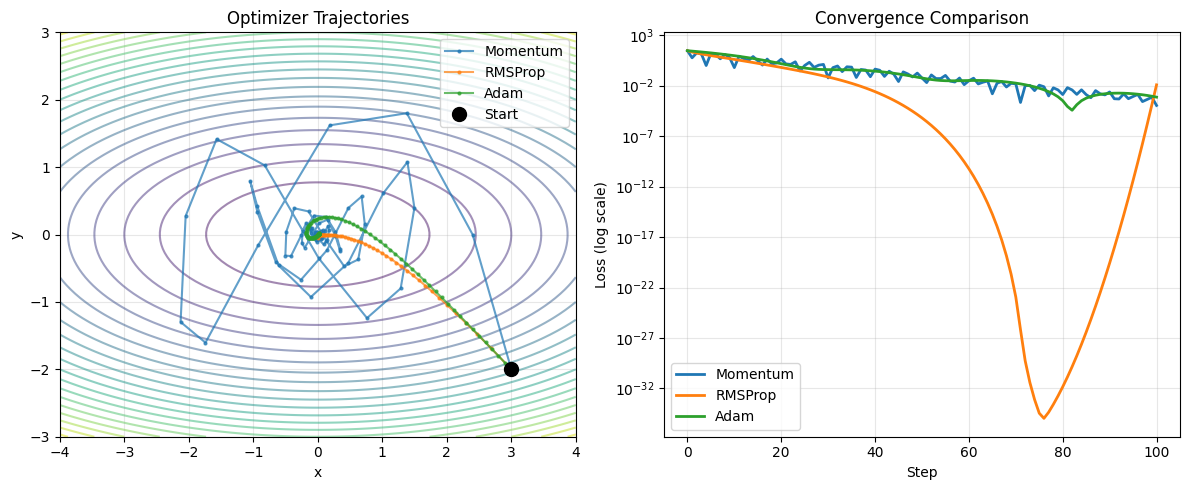

Momentum     final loss: 0.000110
RMSProp      final loss: 0.012053
Adam         final loss: 0.000729


In [4]:

# Define a simple 2D quadratic loss function
def loss_fn(params):
    x, y = params
    return x**2 + 5*y**2

def grad_fn(params):
    x, y = params
    return np.array([2*x, 10*y])

n_steps = 100
initial_params = np.array([3.0, -2.0])

def _run_optimizer(name, opt):
    params = initial_params.copy()
    trajectory = [params.copy()]
    for _ in range(n_steps):
        grads = grad_fn(params)
        params = opt.step(params, grads)
        trajectory.append(params.copy())
    return np.array(trajectory)

optimizer_configs = {
    'Momentum': lambda: MomentumOptimizer(lr=0.1, momentum=0.9),
    'RMSProp': lambda: RMSPropOptimizer(lr=0.1, beta=0.9),
    'Adam':    lambda: AdamOptimizer(lr=0.1, beta1=0.9, beta2=0.999),
}

trajectories = {
    name: cached(f"optimizer_{name.lower()}_{n_steps}steps",
                 lambda n=name, c=cfg: _run_optimizer(n, c()))
    for name, cfg in optimizer_configs.items()
}

# Plot trajectories
plt.figure(figsize=(12, 5))

x_range = np.linspace(-4, 4, 100)
y_range = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = X**2 + 5*Y**2

plt.subplot(1, 2, 1)
plt.contour(X, Y, Z, levels=20, cmap='viridis', alpha=0.5)
for name, traj in trajectories.items():
    plt.plot(traj[:, 0], traj[:, 1], '-o', markersize=2, label=name, alpha=0.7)
plt.plot(initial_params[0], initial_params[1], 'ko', markersize=10, label='Start')
plt.xlabel('x'); plt.ylabel('y')
plt.title('Optimizer Trajectories'); plt.legend(); plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
for name, traj in trajectories.items():
    losses = [loss_fn(p) for p in traj]
    plt.semilogy(losses, label=name, linewidth=2)
plt.xlabel('Step'); plt.ylabel('Loss (log scale)')
plt.title('Convergence Comparison'); plt.legend(); plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

for name, traj in trajectories.items():
    print(f"{name:12s} final loss: {loss_fn(traj[-1]):.6f}")


## 3. Learning Rate Schedules

Experiment with different LR schedules: step decay, cosine annealing, and warmup.

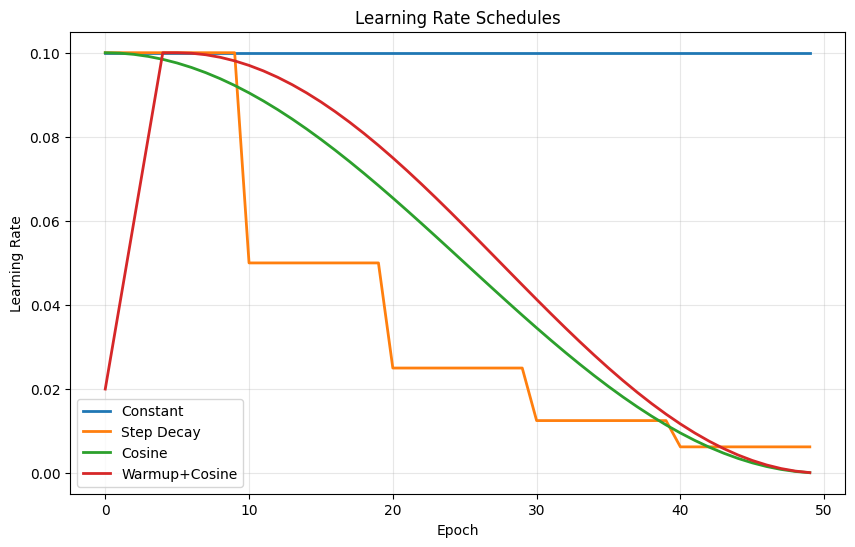

In [5]:
# Learning rate schedulers
def step_decay(epoch, lr_initial, drop_rate=0.5, epochs_drop=10):
    """Step decay LR schedule"""
    return lr_initial * (drop_rate ** (epoch // epochs_drop))

def cosine_annealing(epoch, lr_initial, T_max):
    """Cosine annealing LR schedule"""
    return lr_initial * 0.5 * (1 + np.cos(np.pi * epoch / T_max))

def warmup_cosine(epoch, lr_initial, warmup_epochs=5, T_max=50):
    """Warmup + cosine annealing"""
    if epoch < warmup_epochs:
        return lr_initial * (epoch + 1) / warmup_epochs
    else:
        return cosine_annealing(epoch - warmup_epochs, lr_initial, T_max - warmup_epochs)

# Visualize schedules
epochs = np.arange(0, 50)
lr_initial = 0.1

schedules = {
    'Constant': [lr_initial] * len(epochs),
    'Step Decay': [step_decay(e, lr_initial) for e in epochs],
    'Cosine': [cosine_annealing(e, lr_initial, T_max=50) for e in epochs],
    'Warmup+Cosine': [warmup_cosine(e, lr_initial) for e in epochs]
}

plt.figure(figsize=(10, 6))
for name, schedule in schedules.items():
    plt.plot(epochs, schedule, linewidth=2, label=name)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedules')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Exercises for Further Practice

1. **LR Range Test**: Implement Leslie Smith's LR range test to find optimal LR
2. **Hyperparameter Sensitivity**: Grid search over beta1/beta2 for Adam and plot effects
3. **Non-Convex Losses**: Test optimizers on Rosenbrock function or other challenging landscapes
4. **Adaptive vs Fixed LR**: Compare Adam with fixed LR vs Adam with cosine schedule
5. **Implement AdaGrad**: Add AdaGrad optimizer and compare to Adam/RMSProp

## Deliverables Checklist

- [ ] Optimizer implementations (Momentum, RMSProp, Adam)
- [ ] Comparison plots on at least two problems (convex + non-convex)
- [ ] LR schedule experiments with visualizations  
- [ ] Short write-up explaining which optimizer works best for which problem type

## Recommended Resources

- Kingma & Ba (2014): "Adam: A Method for Stochastic Optimization"
- Ruder (2016): "An overview of gradient descent optimization algorithms"
- Smith (2018): "A disciplined approach to neural network hyper-parameters"

In [6]:

# EXERCISE 1 — LR Range Test
# Goal: implement Leslie Smith's range test: run Adam for 50 steps while
# linearly increasing LR from 1e-4 to 1.0. Plot loss vs LR.
# The "good" LR is just before the loss starts rising. Use cached() for the sweep.
# Expected insight: there is a clear "sweet spot" LR region for every problem.


In [7]:

# EXERCISE 2 — Hyperparameter Sensitivity (beta1/beta2 grid for Adam)
# Goal: create a 5x5 grid of beta1 in [0.5, 0.99] and beta2 in [0.9, 0.9999].
# For each pair, run Adam for 100 steps and record final loss.
# Plot as a heatmap. Use cached(f"adam_beta1_{b1}_beta2_{b2}", ...) per combo.
# Expected insight: Adam is robust within a wide range but breaks at extremes.


In [8]:

# EXERCISE 3 — Non-Convex Loss: Rosenbrock Function
# Goal: test all three optimizers on f(x,y) = (1-x)^2 + 100*(y-x^2)^2.
# Start from (-1, 1). Run 5000 steps. Plot trajectories on a contour plot.
# Use cached(f"rosenbrock_{name}_5000steps", ...) per optimizer.
# Expected insight: Adam and Momentum often struggle here — Rosenbrock is notoriously hard.


In [9]:

# EXERCISE 5 — Implement AdaGrad
# Goal: add an AdaGradOptimizer class that accumulates squared gradients (no decay).
# Compare it to RMSProp on both the quadratic loss and Rosenbrock.
# Expected insight: AdaGrad's learning rate shrinks to near-zero over time,
# while RMSProp's exponential moving average keeps it alive.
